# CV Review: Segmentation and Object Detection

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL
import urllib
from tqdm.notebook import tqdm
import os
from pathlib import Path

import timm
import fastai.vision.all as fastai
from fastai.callback.schedule import Learner
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

seed = 42
np.random.seed(seed + 1)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
device: cuda


In [71]:
def imshow(image, title='', figsize=None):
    if isinstance(image, torch.Tensor) or isinstance(image, torch.FloatTensor):
        with torch.no_grad():
            image = image.numpy().transpose(1, 2, 0)
    if isinstance(image, list):
        image = np.array(image)
        
#     if image.min() >= 0 and image.max() <= 1:
#         image = image * 255
        
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def n_params(model):
    return sum([p.numel() for p in model.parameters()])

# Segmentation

Goal: Given an image, learn a mask of the same size, where each value stands for some category.

Types:
- Semantic Segmentation: Segment the image by the categories that show up
- Instance Segmentation: Segment the image by both the category and the number of segments in that category
- Panoptic Segmentation: Segment the image using pixel-by-pixel object detection

## U-Nets

Transpose Convolution: Used to make the input height/width larger. Undoes convolution in some sense.
- Given $(k,k)$ filter on an input $(h,w)$. The output size is $(h',w')$, initialized to zeros.
- For each element in the input, multiply it by the filter to get a $(k,k)$ window.
- Place the window over the correct spot in the output. Note padding and stride may be used on the output.
- For each value in the window, sum the window value with the current output value, and update the output value.
- Do this until the window convolves over the entire input.

U-Nets: A bottleneck network that squeezes an image down to linear features and then blows it back up into a mask.
- The idea is that compression allows the model to learn the essential features in the image, while decompression allows it to blow back up and learn a mask representation for segmentation.
- Convolution blocks with pooling are used to shrink the image down to a linear representation.
- Transpose convolution blocks are used to blow the representation back up to a mask the same height/width as the image (but with only one channel).
- Residual connections connect blocks of the same size across the U-Net, allowing intermediate features to transfer from input to output. Channel-wise concatenation is used instead of summing.

<img src="https://pytorch.org/assets/images/unet_brain_mri.png" alt="U-Net" width="500"/>

In [4]:
model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch',
    'unet', 
    in_channels=3, 
    out_channels=1, 
    init_features=32, 
    pretrained=True
)

model = model.to(device)

Using cache found in /home/paperspace/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [3]:
summary(model, (3, 256, 256), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14           [-1, 64,

In [5]:
data_path = fastai.untar_data(fastai.URLs.CAMVID_TINY)
data_path

Path('/home/paperspace/.fastai/data/camvid_tiny')

In [6]:
codes = np.loadtxt(data_path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [7]:
fnames = fastai.get_image_files(data_path/"images")
fnames[0]

Path('/home/paperspace/.fastai/data/camvid_tiny/images/0016E5_08009.png')

In [8]:
(data_path/"labels").ls()[0]

Path('/home/paperspace/.fastai/data/camvid_tiny/labels/0001TP_007860_P.png')

In [9]:
def label_func(fn): 
    return data_path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [10]:
dls = fastai.SegmentationDataLoaders.from_label_func(data_path, bs=8, fnames=fnames, 
                                                     label_func=label_func, codes=codes)

/home/paperspace/miniconda3/envs/main/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


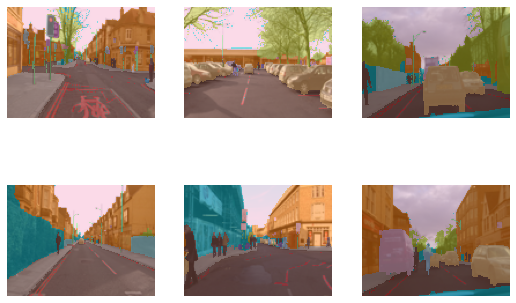

In [11]:
dls.show_batch(max_n=6)

/home/paperspace/miniconda3/envs/main/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=4.365158383734524e-05)

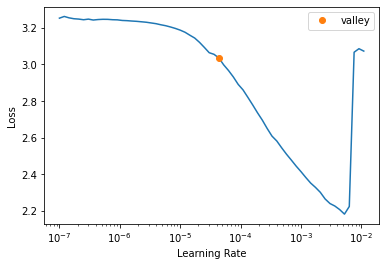

In [13]:
learn = fastai.unet_learner(dls, fastai.resnet34)
learn.lr_find()

In [20]:
learn.fine_tune(15, 5e-5)

epoch,train_loss,valid_loss,time
0,0.551416,0.974582,00:01


epoch,train_loss,valid_loss,time
0,0.547928,0.974784,00:01
1,0.547964,0.981272,00:01
2,0.547462,0.989314,00:01
3,0.543392,0.972027,00:01
4,0.539565,0.985008,00:01
5,0.536382,0.982732,00:01


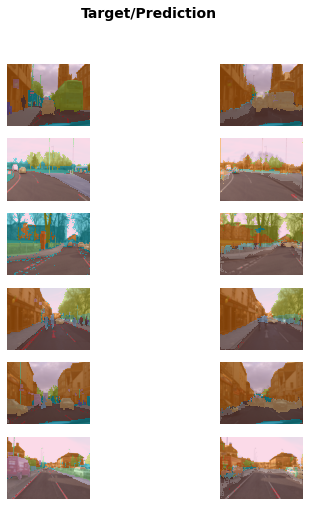

In [21]:
learn.show_results(max_n=6, figsize=(7,8))

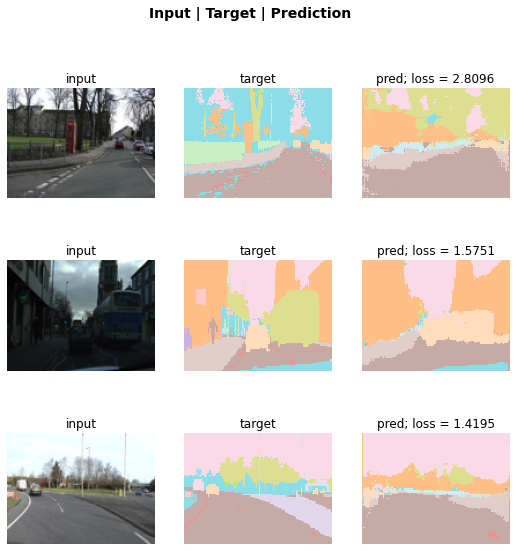

In [22]:
interp = fastai.SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [82]:
x,y = dls.one_batch()
yhat = learn.model(x)
y_pred = yhat.argmax(dim=1)
x.shape, y.shape, yhat.shape, y_pred.shape

(torch.Size([8, 3, 96, 128]),
 torch.Size([8, 96, 128]),
 torch.Size([8, 32, 96, 128]),
 torch.Size([8, 96, 128]))

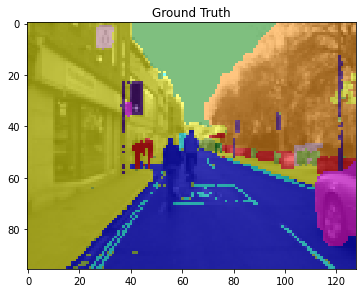

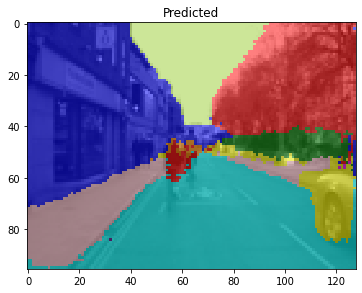

In [87]:
def plot_segmented_image(image, mask, alpha=0.5, title=''):
    from skimage import io, color
    min_max_scale = lambda x: (x - x.min()) / (x.max() - x.min())
    image = min_max_scale(image)
    masked_image = color.label2rgb(mask, image, alpha=alpha)
    io.imshow(masked_image)
    plt.title(title)
    plt.show()
    
mask = y[0].cpu().numpy()
pred = y_pred[0].cpu().numpy()
image = x[0].cpu().numpy().transpose(1, 2, 0)
plot_segmented_image(image, mask, title='Ground Truth')
plot_segmented_image(image, pred, title='Predicted')

# Object Detection

Objection Detection: Object Recognition + Object Localization + Multiple Objects
- Object Recognition: Classify given object according to a set of classes
- Object Localization: Learn the bounding box for a particular object
- Multiple Objects: Need to recognize a set of objects, not necessarily a fixed number of them (or any at all)

## YOLO

- A fully convolutional (no FC layers) for object detection.
- A sliding window moves over the input image, each window performing object detection. Each pixel in the output image is an output vector for that given window containing:
    - The probability an object is in the image
    - The probability of each class of object
    - The 4 coordinates needed to specify a bounding box for that object: one corner $(x,y)$, height, and width
- Low latency model. Efficient for real time detection, but at some model performance cost.
- Bounding box values are often measured as a fraction of the height/width of that window, with $(0,0)$ the top left corner and $(1,1)$ the bottom right corner.
- How to deal with the fact that multiple bounding boxes can be detected for the same object? To get around this, one uses **intersection over union (IOU)** to refine the bounding box predictions. IOU is a measure of how much a set of bounding boxes overlap relative to their union. Given $n$ bounding box predictions for a given object, compute the IOU as below. Judge a bounding box prediction as correct if, say, $\text{IOU} \geq 0.5$, i.e. if the boxes are more or less all on top of each other and not too diffuse.
$$\text{IOU} = \frac{\text{area}(\cap_n \text{boxes})}{\text{area}(\cup_n \text{boxes})}.$$
- How to deal with the problem of multiple windows detecting the same object? To make sure it detects each object only once, one uses **non-max supression (NMS)** on the output. NMS works by only keeping the detection with the highest probability, and suppressing the rest within a given IOU of that bounding box. The NMS algorithm works as follows:
    - For each object class independently:
    - Discard all bounding boxes with an "is object" probability $p_c$ less than some threshold, e.g. 0.6.
    - While there are any remaining bounding boxes:
        - Pick the box with the highest prediction $p_c$ and output that as a prediction
        - Discard any remaining boxes within a given IOU of the above bounding box, e.g. all $\text{IOU} \geq 0.5$.
- What happens if there are multiple objects in the same cell? The trick is to use **anchor boxes**. The idea is to define anchor boxes of different shapes for different object shapes (e.g. human vs car). Given $k$ classes, $4$ bounding box numbers, $p_c$, and $n_a$ anchor boxes, expand the output vector to $n_a(k+4+1)$ values. Make the object matching the shape of anchor box $\alpha$ go in the $(p_c,b_x,b_y,b_h,b_w,c_1,\dots,c_k)_{\alpha}$ slot. This allows objects of different shapes in the same window to be recognized together. The highest IOU anchor box with the ground truth box is chosen for classification. Given an $n \times n$ grid of windows, the outputs are now $(n,n,n_c,k+4+1)$ tensors.
- The algorithm doesn't handle the following situations well:
    - Objects of vastly different scales than the window sizes, e.g. really small objects in an image
    - Objects in the same window that both have the same anchor box shape
    - More objects in a window than the number of anchor boxes (usually just two)
- The loss for training the YOLO algorithm is
$$L = L_{c} + \mathbb{1}_{c=1}(L_{\text{bbox}} + L_{\text{class}}).$$

In [14]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))
    
class Yolo(nn.Module):
    def __init__(self, architecture, split_size, num_boxes, num_classes, in_channels=3):
        super().__init__()
        self.architecture = architecture
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(split_size, num_boxes, num_classes)
        
    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if isinstance(x, tuple):
                layers += [CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif isinstance(x, list):
                conv1 = x[0] # Tuple
                conv2 = x[1] # Tuple
                repeats = x[2] # Int
                
                for _ in range(repeats):
                    layers += [CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])]
                    layers += [CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]
                    
        return nn.Sequential(*layers)
    
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(), 
            nn.Linear(1024 * S * S, 4096), 
            nn.Dropout(0.0), 
            nn.LeakyReLU(0.1), 
            nn.Linear(4096, S * S * (C + B * 5))
        )
    # Original paper uses nn.Linear(1024 * S * S, 4096) not 496. 
    # Also the last layer will be reshaped to (S, S, 13) where C+B*5 = 13
    
architecture = [
    # Tuple: (kernel_size, number of filters, strides, padding)
    # "M" = Max Pool Layer
    # List: [(tuple), (tuple), how many times to repeat]
    # Doesnt include fc layers
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [15]:
model = Yolo(architecture, split_size=7, num_boxes=2, num_classes=3).to(device)
model

Yolo(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBlock(

In [16]:
sum([p.numel() for p in model.parameters()])

268303933

In [17]:
model(torch.rand(1, 3, 416, 416).to(device)).shape

torch.Size([1, 637])

## R-CNNs: Region Proposal Networks

R-CNN: Propose regions using a segmentation algorithm to decide if an object is present. Run detection on each such region to classify and output refined bounding boxes. 

Fast R-CNN: Still uses segmentation to propose regions. But improves the R-CNN by using a fully convolutional implementation of the detection step on all proposed regions, rather than running each region through a network one by one.

Faster R-CNN: Improves the Fast R-CNN by instead learning what regions to propose using another CNN.

Mask R-CNN: Improves Faster R-CNN by not only doing object detection, but panoptic segmentation as well. That is, for each detected object, the network outputs a pixel-by-pixel mask for that object as well.

In [36]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = PIL.Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = PIL.Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
def get_transform(train=True):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [37]:
# ! wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
# ! mv PennFudanPed.zip ~/data
# ! unzip ~/data/PennFudanPed.zip

In [38]:
data = PennFudanDataset(Path().home()/'data'/'PennFudanPed', get_transform(train=True))

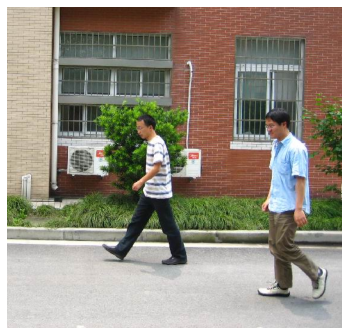

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([0]),
 'area': tensor([35358., 36225.]),
 'iscrowd': tensor([0, 0])}

In [57]:
image, annotation = data[0]
imshow(image, figsize=(6,6))
annotation

In [59]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [61]:
dataloader = torch.utils.data.DataLoader(data, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [69]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/paperspace/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [72]:
n_params(model)

41755286

In [73]:
n_classes = 2  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [76]:
images, targets = next(iter(dataloader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [85]:
targets[0]

{'boxes': tensor([[141., 120., 263., 378.],
         [386.,  75., 515., 364.],
         [444.,  76., 606., 368.]]),
 'labels': tensor([1, 1, 1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([93]),
 'area': tensor([31476., 37281., 47304.]),
 'iscrowd': tensor([0, 0, 0])}

In [79]:
output

{'loss_classifier': tensor(0.6770, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.3146, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0212, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0123, grad_fn=<DivBackward0>)}

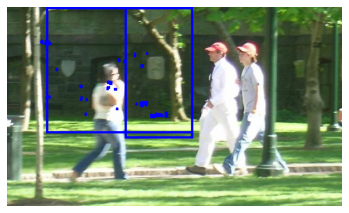

In [115]:
image, boxes = images[0], predictions[0]['boxes'].float()

result = torchvision.utils.draw_bounding_boxes((image * 255).type(torch.uint8), boxes, width=5, colors='blue')
imshow(result)

In [136]:
def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

def train_detection_model(train_loader, model, opt, test_loader=None, num_epochs=10, plot_loss=True,
                          tensorboard=False, print_loss=True, show_batches_bar=False):
    if tensorboard:
        writer = SummaryWriter()
    train_losses = []
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for images, targets in iterator:
            opt.zero_grad()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            opt.step()
            batch_losses.append(float(losses) * train_loader.batch_size)
        train_loss = sum(batch_losses) / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        if test_loader is not None:
            model = model.eval()
            batch_losses = []
            batch_correct = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for images, targets in iterator:
                opt.zero_grad()
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]                
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                batch_losses.append(float(losses)* test_loader.batch_size)
            test_loss = sum(batch_losses) / len(test_loader.dataset)
        else:
            test_loss = -999

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
        if print_loss:
            s1 = f'epoch: {epoch+1: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   test loss: {round(test_loss, 4): <6}' 
            print(s1 + s2)
    if plot_loss:
        plt.plot(range(len(train_losses)), train_losses)
    if tensorboard:
        writer.flush()
        writer.close()
    return model

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 1     train loss: 0.34     test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 2     train loss: 0.3209   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 3     train loss: 0.3119   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 4     train loss: 0.2917   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 5     train loss: 0.2757   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 6     train loss: 0.2717   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 7     train loss: 0.2709   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 8     train loss: 0.2653   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 9     train loss: 0.2487   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 10    train loss: 0.2511   test loss: -999  


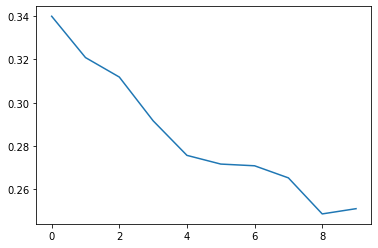

In [137]:
dataloader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True, collate_fn=collate_fn)
model = model.to(device)
opt = get_optimizer(model, optimizer='sgd', lr=0.001)
model = train_detection_model(dataloader, model, opt, test_loader=None, num_epochs=10, show_batches_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 1     train loss: 0.2705   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 2     train loss: 0.2559   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 3     train loss: 0.2523   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 4     train loss: 0.2562   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 5     train loss: 0.2622   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 6     train loss: 0.264    test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 7     train loss: 0.2531   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 8     train loss: 0.2651   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 9     train loss: 0.2579   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 10    train loss: 0.2481   test loss: -999  


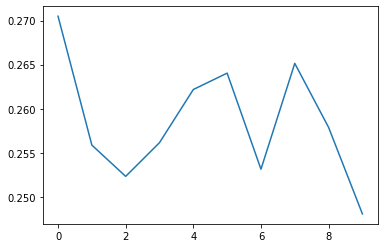

In [138]:
opt = get_optimizer(model, optimizer='sgd', lr=1e-5)
model = train_detection_model(dataloader, model, opt, test_loader=None, num_epochs=10, show_batches_bar=True)

In [200]:
@torch.inference_mode()
def evaluate(model, dataloader, device=device):
    from detection_utils import get_coco_api_from_dataset, CocoEvaluator, get_iou_types
    model.eval().to(device)
    coco = get_coco_api_from_dataset(dataloader.dataset)
    iou_types = get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in tqdm(dataloader):
        images = list(img.to(device) for img in images)
        outputs = model(images)
        outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
        result = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(result)


    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

    return coco_evaluator

In [158]:
evaluate(model, dataloader)

creating index...
index created!


  0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [185]:
def plot_bboxes(dataset, idx, pred=False, model=None):
    image, target = dataset[idx]
    image, target = image.to(device), {k:v.to(device) for k,v in target.items()}
    # output = model(image[None, :], [target])
    if pred:
        model = model.eval()
        predictions = model(image[None, :])
    boxes = target['boxes'].float() if not pred else predictions[0]['boxes'].float()
    result = torchvision.utils.draw_bounding_boxes((image * 255).type(torch.uint8), boxes, width=5, colors='blue')
    imshow(result)

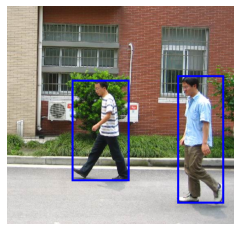

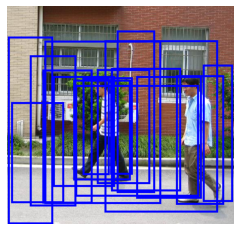

In [173]:
test_data = PennFudanDataset(Path().home()/'data'/'PennFudanPed', get_transform(train=False))
plot_bboxes(test_data, 0, pred=False)
plot_bboxes(test_data, 0, pred=True, model=model)

In [179]:
def get_model_instance_segmentation():
    num_classes = 2
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

model = get_model_instance_segmentation()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 1     train loss: 1.0093   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 2     train loss: 0.7426   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 3     train loss: 0.7051   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 4     train loss: 0.7003   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 5     train loss: 0.6607   test loss: -999  


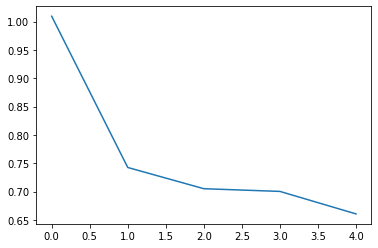

In [180]:
dataloader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=True, collate_fn=collate_fn)
model = model.to(device)
opt = get_optimizer(model, optimizer='sgd', lr=0.005, momentum=0.9, weight_decay=0.0005)
model = train_detection_model(dataloader, model, opt, test_loader=None, num_epochs=5, show_batches_bar=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 1     train loss: 0.5761   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 2     train loss: 0.5752   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 3     train loss: 0.6016   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 4     train loss: 0.5656   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 5     train loss: 0.5645   test loss: -999  


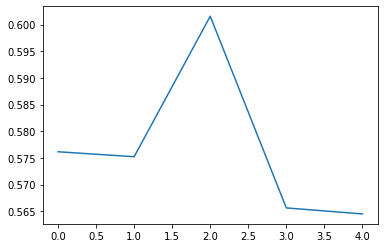

In [181]:
opt = get_optimizer(model, optimizer='sgd', lr=0.0005, momentum=0.9, weight_decay=0.0005)
model = train_detection_model(dataloader, model, opt, test_loader=None, num_epochs=5, show_batches_bar=True)

In [183]:
opt = get_optimizer(model, optimizer='sgd', lr=0.00005, momentum=0.9, weight_decay=0.0005)
model = train_detection_model(dataloader, model, opt, test_loader=None, num_epochs=5, show_batches_bar=True, plot_loss=False)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 1     train loss: 0.5459   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 2     train loss: 0.5098   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 3     train loss: 0.5413   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 4     train loss: 0.5221   test loss: -999  


  0%|          | 0/170 [00:00<?, ?it/s]

epoch: 5     train loss: 0.5444   test loss: -999  


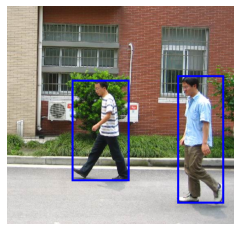

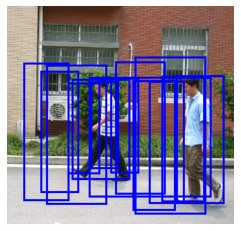

In [186]:
plot_bboxes(test_data, 0, pred=False)
plot_bboxes(test_data, 0, pred=True, model=model)

In [202]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=collate_fn)
evaluate(model, test_loader, device='cpu')

creating index...
index created!


  0%|          | 0/170 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.933
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.900

In [218]:
def plot_masks(dataset, idx, pred=False, model=None, device=device):
    image, target = dataset[idx]
    image, target = image.to(device), {k:v.to(device) for k,v in target.items()}
    if pred:
        model = model.eval()
        with torch.no_grad():
            predictions = model(image[None, :])
    output = target['masks'].float() if not pred else predictions[0]['masks'].float()
    masks = torch.nn.functional.softmax(output, dim=1)
    imshow(masks.cpu())

In [1]:
#plot_masks(test_data, 0, pred=False)
#plot_masks(test_data, 0, pred=True, model=model)

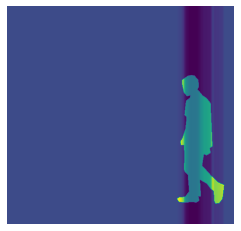

In [229]:
idx = 0
pred = False

image, target = data[idx]
image, target = image.to(device), {k:v.to(device) for k,v in target.items()}
if pred:
    model = model.eval()
    with torch.no_grad():
        predictions = model(image[None, :])
output = target['masks'].float() if not pred else predictions[0]['masks'].float()
masks = torch.nn.functional.softmax(output, dim=1)
imshow(masks.cpu().numpy()[1])